In [1]:
import os
import sys
import pandas as pd

module_path = os.path.abspath(os.path.join(".."))
sys.path.append(module_path)

In [2]:
from other import create_features

df = pd.read_csv("../dataset/810.csv")
dataset = create_features(df, model_name="")
print(dataset.shape)

(267547, 8)


In [3]:
dataset

,card_id,review_th,delta_t,rating,i,r_history,t_history,y
8926,518.0,318.0,1.0,3.0,2.0,3,0,1.0
10954,624.0,319.0,1.0,3.0,2.0,3,0,1.0
10633,608.0,320.0,1.0,2.0,2.0,3,0,1.0
10186,578.0,322.0,1.0,3.0,2.0,1,0,1.0
10524,599.0,324.0,1.0,3.0,2.0,3,0,1.0
...,...,...,...,...,...,...,...,...
355831,23169.0,368804.0,1017.0,2.0,12.0,"3,2,3,2,3,3,1,2,4,4,4","0,1,3,10,17,28,705,1,3,9,24",1.0
78649,6485.0,368805.0,1165.0,3.0,3.0,"4,4","0,3",1.0
346049,22098.0,368806.0,618.0,3.0,7.0,"3,2,3,3,1,2","0,3,2,101,210,1",1.0
345521,22032.0,368807.0,616.0,3.0,7.0,"3,2,3,1,2,1","0,3,103,210,1,2",1.0


In [4]:
dataset[dataset["r_history"].str.endswith("1")]["r_history"].value_counts()

r_history
1                                          9279
1,1                                        2685
3,1                                         931
1,1,1                                       918
1,2,1                                       701
                                           ... 
3,2,2,2,2,2,2,2,2,2,2,3,2,2,3,3,3,4,3,1       1
1,3,2,1,2,2,3,3,3,3,3,1,3,3,3,3,3,3,1         1
1,2,1,2,3,3,3,3,1,3,4,3,4,3,3,1               1
3,2,3,2,3,3,2,3,3,3,1                         1
3,3,2,3,1,1                                   1
Name: count, Length: 12057, dtype: int64

In [5]:
first_rating = 1

tmp = dataset[dataset["r_history"] == f"{first_rating},1"]
print(tmp["t_history"].value_counts().head(5))
tmp

t_history
0,1    2060
0,2     344
0,3     123
0,4      75
0,6      24
Name: count, dtype: int64


,card_id,review_th,delta_t,rating,i,r_history,t_history,y
10831,620.0,1068.0,1.0,1.0,3.0,"1,1","0,1",0.0
10367,590.0,1070.0,1.0,2.0,3.0,"1,1","0,1",1.0
11093,635.0,1078.0,1.0,2.0,3.0,"1,1","0,1",1.0
10914,623.0,1080.0,1.0,2.0,3.0,"1,1","0,1",1.0
10765,618.0,1090.0,1.0,2.0,3.0,"1,1","0,1",1.0
...,...,...,...,...,...,...,...,...
346101,22105.0,368380.0,103.0,3.0,3.0,"1,1","0,3",1.0
346163,22114.0,368404.0,103.0,1.0,3.0,"1,1","0,3",0.0
345848,22072.0,368409.0,103.0,1.0,3.0,"1,1","0,3",0.0
346215,22123.0,368766.0,1.0,2.0,3.0,"1,1","0,1",1.0


last_ivl: 1, last_r: 0.717, s: 0.202, next_r: 0.674, total_cnt: 2060
last_ivl: 2, last_r: 0.676, s: 0.191, next_r: 0.654, total_cnt: 344
last_ivl: 3, last_r: 0.669, s: 0.191, next_r: 0.662, total_cnt: 123
last_ivl: 4, last_r: 0.576, s: 0.256, next_r: 0.633, total_cnt: 75


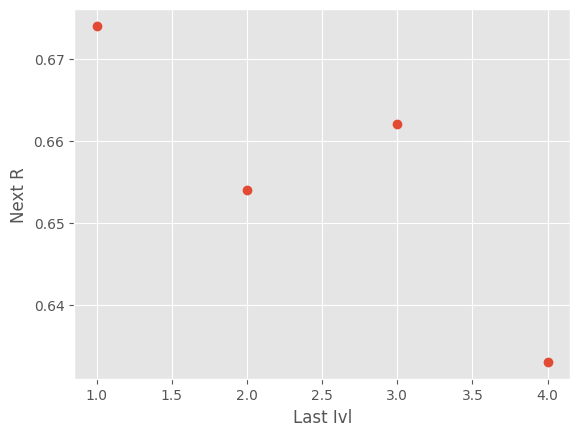

In [6]:
from scipy.optimize import curve_fit
import numpy as np
from fsrs_optimizer import power_forgetting_curve
import matplotlib.pyplot as plt

plt.style.use("ggplot")

last_r_values = []
s_values = []
next_r_values = []

for last_ivl in range(1, 5):
    group = (
        tmp[tmp["t_history"] == f"0,{last_ivl}"]
        .groupby("delta_t")
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )

    total_cnt = group[("y", "count")].sum()

    next_r = round(group[group["delta_t"] == 1][("y", "mean")].values[0], 3)

    s = round(
        curve_fit(
            power_forgetting_curve,
            group["delta_t"],
            group[("y", "mean")],
            sigma=1 / np.sqrt(group[("y", "count")]),
        )[0][0],
        3,
    )

    last_r = round(dataset[(dataset["r_history"] == str(first_rating)) & (dataset["delta_t"] == last_ivl)]["y"].mean(), 3)
    print(f"last_ivl: {last_ivl}, last_r: {last_r}, s: {s}, next_r: {next_r}, total_cnt: {total_cnt}")
    last_r_values.append(last_r)
    s_values.append(s)
    next_r_values.append(next_r)


plt.plot(range(1, 5), next_r_values, "o")
plt.xlabel("Last Ivl")
plt.ylabel("Next R")
plt.show()